In [ ]:
import random
import torch
import time
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# Ensure matplotlib plots inline in the Jupyter notebook
%matplotlib inline

class SudokuGenerator:
    def __init__(self):
        self.base = 3  # Size of the base Sudoku grid (for a 9x9 grid)
        self.side = self.base * self.base
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'  # Use CUDA if available

    # Create a full solution using a backtracking algorithm
    def solve(self, grid):
        find = self.find_empty(grid)
        if not find:
            return True  # Solved
        row, col = find

        for num in range(1, self.side + 1):
            if self.is_safe(grid, num, row, col):
                grid[row][col] = num

                if self.solve(grid):
                    return True

                grid[row][col] = 0

        return False

    # Check if it's safe to place a number in a given cell
    def is_safe(self, grid, num, row, col):
        if num in grid[row]:
            return False
        if num in [grid[i][col] for i in range(self.side)]:
            return False
        box_x = row // self.base * self.base
        box_y = col // self.base * self.base
        for i in range(self.base):
            for j in range(self.base):
                if grid[box_x + i][box_y + j] == num:
                    return False
        return True

    # Find the next empty cell
    def find_empty(self, grid):
        for i in range(self.side):
            for j in range(self.side):
                if grid[i][j] == 0:
                    return (i, j)
        return None

    # Generate a fully solved grid
    def generate_solution_grid(self):
        grid = torch.zeros((self.side, self.side), dtype=torch.int8, device=self.device)  # Use CUDA tensor
        self.fill_diagonal_boxes(grid)
        self.solve(grid)
        return grid

    # Fill the diagonal 3x3 boxes with random numbers
    def fill_diagonal_boxes(self, grid):
        for i in range(0, self.side, self.base):
            self.fill_box(grid, i, i)

    # Fill a 3x3 box
    def fill_box(self, grid, row, col):
        numbers = list(range(1, self.side + 1))
        random.shuffle(numbers)
        for i in range(self.base):
            for j in range(self.base):
                grid[row + i][col + j] = numbers.pop()

    # Remove numbers to create the puzzle
    def remove_numbers(self, grid, num_holes):
        puzzle = grid.clone()  # Create a copy of the grid
        count = num_holes
        while count > 0:
            row = random.randint(0, self.side - 1)
            col = random.randint(0, self.side - 1)
            if puzzle[row][col] != 0:
                puzzle[row][col] = 0
                count -= 1
        return puzzle

    # Generate multiple puzzles and solutions as int8 tensors
    def generate_puzzles(self, num_puzzles=5):
        puzzles = torch.zeros((num_puzzles, self.side, self.side), dtype=torch.int8, device=self.device)
        solutions = torch.zeros((num_puzzles, self.side, self.side), dtype=torch.int8, device=self.device)

        generation_times = []  # List to store generation times for each puzzle

        for idx in range(num_puzzles):
            start_time = time.time()  # Record the start time for puzzle generation

            solution = self.generate_solution_grid()
            num_holes = random.randint(12, 40)  # Random number of holes between 12 and 40
            puzzle = self.remove_numbers(solution, num_holes)
            puzzles[idx] = puzzle
            solutions[idx] = solution

            end_time = time.time()  # Record the end time for puzzle generation
            elapsed_time = end_time - start_time  # Calculate elapsed time
            generation_times.append(elapsed_time)  # Append time to list

            # Convert to tensor for calculations
            generation_times_tensor = torch.tensor(generation_times, device=self.device, dtype=torch.float)

            # Calculate mean, standard deviation, and median using PyTorch
            mean_time = generation_times_tensor.mean().item()
            std_time = generation_times_tensor.std().item()
            median_time = generation_times_tensor.median().item()

            # Print the time taken for each puzzle and current mean, std, and median
            print(f"Puzzle {idx + 1} generated in {elapsed_time:.4f} seconds. "
                  f"Mean Time: {mean_time:.4f}s, Std: {std_time:.4f}s, Median: {median_time:.4f}s")

            # Live updating of the plot
            fig, ax = plt.subplots(figsize=(12, 6))  # Create a figure and axis object
            ax.plot(range(1, len(generation_times) + 1), generation_times, marker='o', color='b', label='Generation Time')
            ax.axhline(mean_time, color='r', linestyle='--', label=f'Mean: {mean_time:.4f}s')
            ax.axhline(median_time, color='g', linestyle='--', label=f'Median: {median_time:.4f}s')
            ax.fill_between(range(1, len(generation_times) + 1),
                             mean_time - std_time,
                             mean_time + std_time,
                             color='orange', alpha=0.3, label=f'Std: {std_time:.4f}s')

            ax.set_title('Sudoku Puzzle Generation Times')
            ax.set_xlabel('Puzzle Index')
            ax.set_ylabel('Time (seconds)')
            ax.legend()
            ax.grid(True)
            clear_output(wait=True)  # Clear previous plot
            display(fig)  # Display the current plot
            plt.close(fig)  # Close the figure to avoid retaining old plots

        return puzzles, solutions

# Example usage
sudoku = SudokuGenerator()
puzzles, solutions = sudoku.generate_puzzles(num_puzzles=1000)

print(puzzles.size(), solutions.size())


## Without any  parallel operations 1000 sudoku puzzles took 1 hour to generate whitch is a joke

also a quick check for the duplicats , but for such a small quantity it should not be a problem YET

In [ ]:


# Reshape the tensor to 1000 x 81 (9*9=81)
reshaped_tensor = solutions.view(solutions.size(0), -1)

# Get unique rows and their indices
unique_rows, indices = torch.unique(reshaped_tensor, dim=0, return_inverse=True)

# Check for duplicates
duplicates = torch.bincount(indices) > 1

# Get the indices of duplicate rows
duplicate_indices = duplicates.nonzero(as_tuple=True)[0]

# Print results
print("Duplicate rows found at indices:", duplicate_indices)


Now , here comes the simillar code but with parallel generation

In [ ]:
import random
import torch
from concurrent.futures import ThreadPoolExecutor, TimeoutError
import time

class SudokuGenerator:
    def __init__(self):
        self.base = 3  # Size of the base Sudoku grid
        self.side = self.base * self.base
        self.times = []

    def solve(self, grid, row, col, num):
        for n in range(1, self.side + 1):
            if self.is_safe(grid, n, row, col):
                grid[row][col] = n
                if self.solve(grid, *self.find_empty(grid)):
                    return True
                grid[row][col] = 0
        return False

    def is_safe(self, grid, num, row, col):
        return (num not in grid[row] and
                num not in grid[:, col] and
                num not in grid[row // self.base * self.base: (row // self.base + 1) * self.base,
                               col // self.base * self.base: (col // self.base + 1) * self.base])

    def generate_solution_grid(self):
        grid = torch.zeros((self.side, self.side), dtype=torch.int8)
        self.fill_diagonal_boxes(grid)
        self.solve(grid, 0, 0, None)
        return grid

    def fill_diagonal_boxes(self, grid):
        for i in range(0, self.side, self.base):
            self.fill_box(grid, i, i)

    def fill_box(self, grid, row, col):
        numbers = list(range(1, self.side + 1))
        random.shuffle(numbers)
        for i in range(self.base):
            for j in range(self.base):
                grid[row + i][col + j] = numbers.pop()

    def remove_numbers(self, grid, num_holes):
        puzzle = grid.clone()
        cells = list(range(self.side * self.side))
        random.shuffle(cells)

        for index in cells[:num_holes]:
            row, col = divmod(index, self.side)
            puzzle[row][col] = 0

        return puzzle

    def generate_single_puzzle(self):
        start_time = time.time()
        solution = self.generate_solution_grid()
        num_holes = random.randint(12, 40)
        puzzle = self.remove_numbers(solution, num_holes)
        elapsed_time = time.time() - start_time
        self.times.append(elapsed_time)
        return puzzle, solution

    def generate_puzzles(self, num_puzzles=5):
        puzzles = torch.zeros((num_puzzles, self.side, self.side), dtype=torch.int8)
        solutions = torch.zeros((num_puzzles, self.side, self.side), dtype=torch.int8)

        with ThreadPoolExecutor(max_workers=20) as executor:
            futures = [executor.submit(self.generate_single_puzzle) for _ in range(num_puzzles)]
            for idx, future in enumerate(futures):
                try:
                    puzzle, solution = future.result(timeout=6)
                    puzzles[idx] = puzzle
                    solutions[idx] = solution
                except TimeoutError:
                    print(f"Puzzle {idx + 1} generation timed out.")

        return puzzles, solutions

# Example usage
if __name__ == "__main__":
    sudoku = SudokuGenerator()
    puzzles1, solutions1 = sudoku.generate_puzzles(num_puzzles=100000)
    print(puzzles1.size(), solutions1.size())


In [ ]:
import random
import torch
from concurrent.futures import ThreadPoolExecutor, TimeoutError
import time
from tqdm import tqdm  # Import tqdm for the loading bar

class SudokuGenerator:
    def __init__(self):
        self.base = 3  # Size of the base Sudoku grid
        self.side = self.base * self.base
        self.times = []

    def solve(self, grid, row, col, num):
        for n in range(1, self.side + 1):
            if self.is_safe(grid, n, row, col):
                grid[row][col] = n
                if self.solve(grid, *self.find_empty(grid)):
                    return True
                grid[row][col] = 0
        return False

    def is_safe(self, grid, num, row, col):
        return (num not in grid[row] and
                num not in grid[:, col] and
                num not in grid[row // self.base * self.base: (row // self.base + 1) * self.base,
                               col // self.base * self.base: (col // self.base + 1) * self.base])

    def generate_solution_grid(self):
        grid = torch.zeros((self.side, self.side), dtype=torch.int8)
        self.fill_diagonal_boxes(grid)
        self.solve(grid, 0, 0, None)
        return grid

    def fill_diagonal_boxes(self, grid):
        for i in range(0, self.side, self.base):
            self.fill_box(grid, i, i)

    def fill_box(self, grid, row, col):
        numbers = list(range(1, self.side + 1))
        random.shuffle(numbers)
        for i in range(self.base):
            for j in range(self.base):
                grid[row + i][col + j] = numbers.pop()

    def remove_numbers(self, grid, num_holes):
        puzzle = grid.clone()
        cells = list(range(self.side * self.side))
        random.shuffle(cells)

        for index in cells[:num_holes]:
            row, col = divmod(index, self.side)
            puzzle[row][col] = 0

        return puzzle

    def generate_single_puzzle(self):
        start_time = time.time()
        solution = self.generate_solution_grid()
        num_holes = random.randint(12, 40)
        puzzle = self.remove_numbers(solution, num_holes)
        elapsed_time = time.time() - start_time
        self.times.append(elapsed_time)
        return puzzle, solution

    def generate_puzzles(self, num_puzzles=5):
        puzzles = torch.zeros((num_puzzles, self.side, self.side), dtype=torch.int8)
        solutions = torch.zeros((num_puzzles, self.side, self.side), dtype=torch.int8)

        with ThreadPoolExecutor(max_workers=20) as executor:
            futures = [executor.submit(self.generate_single_puzzle) for _ in range(num_puzzles)]
            for idx, future in tqdm(enumerate(futures), total=num_puzzles, desc="Generating Puzzles"):
                try:
                    puzzle, solution = future.result(timeout=6)
                    puzzles[idx] = puzzle
                    solutions[idx] = solution
                except TimeoutError:
                    print(f"Puzzle {idx + 1} generation timed out.")

        return puzzles, solutions

# Example usage
if __name__ == "__main__":
    sudoku = SudokuGenerator()
    puzzles1, solutions1 = sudoku.generate_puzzles(num_puzzles=100000)
    print(puzzles1.size(), solutions1.size())


In [ ]:
# Reshape the tensor to 1000 x 81 (9*9=81)
reshaped_tensor = solutions1.view(solutions1.size(0), -1)

# Get unique rows and their indices
unique_rows, indices = torch.unique(reshaped_tensor, dim=0, return_inverse=True)

# Check for duplicates
duplicates = torch.bincount(indices) > 1

# Get the indices of duplicate rows
duplicate_indices = duplicates.nonzero(as_tuple=True)[0]

# Print results
print("Duplicate rows found at indices:", duplicate_indices)

### here is the same code but with some visualizations for better understanding

In [ ]:
import random
import torch
import time
from concurrent.futures import ThreadPoolExecutor, TimeoutError
from tqdm import tqdm  # Import tqdm for the loading bar
import matplotlib.pyplot as plt  # Import for plotting
from IPython.display import display  # For displaying the plot in Jupyter

class SudokuGenerator:
    def __init__(self):
        self.base = 3  # Size of the base Sudoku grid
        self.side = self.base * self.base
        self.times = []  # List to store generation times

    def solve(self, grid, row, col, num):
        for n in range(1, self.side + 1):
            if self.is_safe(grid, n, row, col):
                grid[row][col] = n
                if self.solve(grid, *self.find_empty(grid)):
                    return True
                grid[row][col] = 0
        return False

    def is_safe(self, grid, num, row, col):
        return (num not in grid[row] and
                num not in grid[:, col] and
                num not in grid[row // self.base * self.base: (row // self.base + 1) * self.base,
                               col // self.base * self.base: (col // self.base + 1) * self.base])

    def generate_solution_grid(self):
        grid = torch.zeros((self.side, self.side), dtype=torch.int8)
        self.fill_diagonal_boxes(grid)
        self.solve(grid, 0, 0, None)
        return grid

    def fill_diagonal_boxes(self, grid):
        for i in range(0, self.side, self.base):
            self.fill_box(grid, i, i)

    def fill_box(self, grid, row, col):
        numbers = list(range(1, self.side + 1))
        random.shuffle(numbers)
        for i in range(self.base):
            for j in range(self.base):
                grid[row + i][col + j] = numbers.pop()

    def remove_numbers(self, grid, num_holes):
        puzzle = grid.clone()
        cells = list(range(self.side * self.side))
        random.shuffle(cells)

        for index in cells[:num_holes]:
            row, col = divmod(index, self.side)
            puzzle[row][col] = 0

        return puzzle

    def generate_single_puzzle(self):
        start_time = time.time()
        solution = self.generate_solution_grid()
        num_holes = random.randint(12, 40)
        puzzle = self.remove_numbers(solution, num_holes)
        elapsed_time = time.time() - start_time
        self.times.append(elapsed_time)
        return puzzle, solution

    def generate_puzzles(self, num_puzzles=5):
        puzzles = torch.zeros((num_puzzles, self.side, self.side), dtype=torch.int8)
        solutions = torch.zeros((num_puzzles, self.side, self.side), dtype=torch.int8)

        with ThreadPoolExecutor(max_workers=20) as executor:
            futures = [executor.submit(self.generate_single_puzzle) for _ in range(num_puzzles)]
            for idx, future in tqdm(enumerate(futures), total=num_puzzles, desc="Generating Puzzles"):
                try:
                    puzzle, solution = future.result(timeout=6)
                    puzzles[idx] = puzzle
                    solutions[idx] = solution
                except TimeoutError:
                    print(f"Puzzle {idx + 1} generation timed out.")

        # Calculate statistics after all puzzles are generated
        times_tensor = torch.tensor(self.times, dtype=torch.float32)
        mean_time = torch.mean(times_tensor).item()
        std_time = torch.std(times_tensor).item()
        median_time = torch.median(times_tensor).item()

        # Create a final plot after generating all puzzles
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(range(1, len(self.times) + 1), self.times, marker='o', color='b', label='Generation Time')
        ax.axhline(mean_time, color='r', linestyle='--', label=f'Mean: {mean_time:.4f}s')
        ax.axhline(median_time, color='g', linestyle='--', label=f'Median: {median_time:.4f}s')
        ax.fill_between(range(1, len(self.times) + 1),
                         mean_time - std_time,
                         mean_time + std_time,
                         color='orange', alpha=0.3, label=f'Std: {std_time:.4f}s')

        ax.set_title('Sudoku Puzzle Generation Times')
        ax.set_xlabel('Puzzle Index')
        ax.set_ylabel('Time (seconds)')
        ax.legend()
        ax.grid(True)
        display(fig)  # Display the final plot

        return puzzles, solutions

# Example usage
if __name__ == "__main__":
    sudoku = SudokuGenerator()
    puzzles1, solutions1 = sudoku.generate_puzzles(num_puzzles=500)
    print(puzzles1.size(), solutions1.size())


In [ ]:
import random
import torch
import time
from concurrent.futures import ThreadPoolExecutor, TimeoutError
from tqdm import tqdm  # Import tqdm for the loading bar
import matplotlib.pyplot as plt  # Import for plotting
from IPython.display import display  # For displaying the plot in Jupyter

class SudokuGenerator:
    def __init__(self):
        self.base = 3  # Size of the base Sudoku grid
        self.side = self.base * self.base
        self.times = []  # List to store generation times

    def solve(self, grid, row, col, num):
        for n in range(1, self.side + 1):
            if self.is_safe(grid, n, row, col):
                grid[row][col] = n
                if self.solve(grid, *self.find_empty(grid)):
                    return True
                grid[row][col] = 0
        return False

    def is_safe(self, grid, num, row, col):
        return (num not in grid[row] and
                num not in grid[:, col] and
                num not in grid[row // self.base * self.base: (row // self.base + 1) * self.base,
                               col // self.base * self.base: (col // self.base + 1) * self.base])

    def generate_solution_grid(self):
        grid = torch.zeros((self.side, self.side), dtype=torch.int8)
        self.fill_diagonal_boxes(grid)
        self.solve(grid, 0, 0, None)
        return grid

    def fill_diagonal_boxes(self, grid):
        for i in range(0, self.side, self.base):
            self.fill_box(grid, i, i)

    def fill_box(self, grid, row, col):
        numbers = list(range(1, self.side + 1))
        random.shuffle(numbers)
        for i in range(self.base):
            for j in range(self.base):
                grid[row + i][col + j] = numbers.pop()

    def remove_numbers(self, grid, num_holes):
        puzzle = grid.clone()
        cells = list(range(self.side * self.side))
        random.shuffle(cells)

        for index in cells[:num_holes]:
            row, col = divmod(index, self.side)
            puzzle[row][col] = 0

        return puzzle

    def generate_single_puzzle(self):
        start_time = time.time()
        solution = self.generate_solution_grid()
        num_holes = random.randint(12, 40)
        puzzle = self.remove_numbers(solution, num_holes)
        elapsed_time = time.time() - start_time
        self.times.append(elapsed_time)
        return puzzle, solution

    def generate_puzzles(self, num_puzzles=5):
        puzzles = torch.zeros((num_puzzles, self.side, self.side), dtype=torch.int8)
        solutions = torch.zeros((num_puzzles, self.side, self.side), dtype=torch.int8)

        with ThreadPoolExecutor(max_workers=20) as executor:
            futures = [executor.submit(self.generate_single_puzzle) for _ in range(num_puzzles)]
            for idx, future in tqdm(enumerate(futures), total=num_puzzles, desc="Generating Puzzles"):
                try:
                    puzzle, solution = future.result(timeout=6)
                    puzzles[idx] = puzzle
                    solutions[idx] = solution
                except TimeoutError:
                    print(f"Puzzle {idx + 1} generation timed out.")

        # Calculate statistics after all puzzles are generated
        times_tensor = torch.tensor(self.times, dtype=torch.float32)
        mean_time = torch.mean(times_tensor).item()
        std_time = torch.std(times_tensor).item()
        median_time = torch.median(times_tensor).item()

        # Create a final plot after generating all puzzles
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(range(1, len(self.times) + 1), self.times, color='b', label='Generation Time')  # No markers
        ax.axhline(mean_time, color='r', linestyle='--', label=f'Mean: {mean_time:.4f}s')
        ax.axhline(median_time, color='g', linestyle='--', label=f'Median: {median_time:.4f}s')
        ax.fill_between(range(1, len(self.times) + 1),
                         mean_time - std_time,
                         mean_time + std_time,
                         color='orange', alpha=0.3, label=f'Std: {std_time:.4f}s')

        ax.set_title('Sudoku Puzzle Generation Times')
        ax.set_xlabel('Puzzle Index')
        ax.set_ylabel('Time (seconds)')
        ax.legend()
        ax.grid(True)
        display(fig)  # Display the final plot

        return puzzles, solutions

# Example usage
if __name__ == "__main__":
    sudoku = SudokuGenerator()
    puzzles1, solutions1 = sudoku.generate_puzzles(num_puzzles=1000000)
    print(puzzles1.size(), solutions1.size())


In [ ]:
import random
import torch
import time
from concurrent.futures import ThreadPoolExecutor, TimeoutError
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import display

class SudokuGenerator:
    def __init__(self):
        self.base = 3  # Size of the base Sudoku grid
        self.side = self.base * self.base
        self.times = []  # List to store generation times

    def solve(self, grid, row, col, num):
        for n in range(1, self.side + 1):
            if self.is_safe(grid, n, row, col):
                grid[row][col] = n
                if self.solve(grid, *self.find_empty(grid)):
                    return True
                grid[row][col] = 0
        return False

    def is_safe(self, grid, num, row, col):
        return (num not in grid[row] and
                num not in grid[:, col] and
                num not in grid[row // self.base * self.base: (row // self.base + 1) * self.base,
                               col // self.base * self.base: (col // self.base + 1) * self.base])

    def generate_solution_grid(self):
        grid = torch.zeros((self.side, self.side), dtype=torch.int8)
        self.fill_all_boxes(grid)  # Fill all 3x3 boxes
        self.solve(grid, 0, 0, None)
        return grid

    def fill_all_boxes(self, grid):
        for i in range(self.base):
            for j in range(self.base):
                self.fill_box(grid, i * self.base, j * self.base)

    def fill_box(self, grid, row, col):
        numbers = list(range(1, self.side + 1))
        random.shuffle(numbers)
        for i in range(self.base):
            for j in range(self.base):
                grid[row + i][col + j] = numbers.pop()

    def remove_numbers(self, grid, num_holes):
        puzzle = grid.clone()
        cells = list(range(self.side * self.side))
        random.shuffle(cells)

        for index in cells[:num_holes]:
            row, col = divmod(index, self.side)
            puzzle[row][col] = 0

        return puzzle

    def generate_single_puzzle(self):
        start_time = time.time()
        solution = self.generate_solution_grid()
        num_holes = random.randint(12, 40)
        puzzle = self.remove_numbers(solution, num_holes)
        elapsed_time = time.time() - start_time
        self.times.append(elapsed_time)
        return puzzle, solution

    def generate_puzzles(self, num_puzzles=5, max_workers=20):
        puzzles = torch.zeros((num_puzzles, self.side, self.side), dtype=torch.int8)
        solutions = torch.zeros((num_puzzles, self.side, self.side), dtype=torch.int8)

        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            futures = [executor.submit(self.generate_single_puzzle) for _ in range(num_puzzles)]
            for idx, future in tqdm(enumerate(futures), total=num_puzzles, desc="Generating Puzzles"):
                try:
                    puzzle, solution = future.result(timeout=6)
                    puzzles[idx] = puzzle
                    solutions[idx] = solution
                except TimeoutError:
                    print(f"Puzzle {idx + 1} generation timed out. Retrying...")

        # Calculate statistics after all puzzles are generated
        times_tensor = torch.tensor(self.times, dtype=torch.float32)
        mean_time = torch.mean(times_tensor).item()
        std_time = torch.std(times_tensor).item()
        median_time = torch.median(times_tensor).item()

        # Create a final plot after generating all puzzles
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(range(1, len(self.times) + 1), self.times, color='b', label='Generation Time')
        ax.axhline(mean_time, color='r', linestyle='--', label=f'Mean: {mean_time:.4f}s')
        ax.axhline(median_time, color='g', linestyle='--', label=f'Median: {median_time:.4f}s')
        ax.fill_between(range(1, len(self.times) + 1),
                         mean_time - std_time,
                         mean_time + std_time,
                         color='orange', alpha=0.3, label=f'Std: {std_time:.4f}s')

        ax.set_title('Sudoku Puzzle Generation Times')
        ax.set_xlabel('Puzzle Index')
        ax.set_ylabel('Time (seconds)')
        ax.legend()
        ax.grid(True)
        display(fig)

        return puzzles, solutions

def plot_sudoku(puzzles, solutions, n=5):
    # Randomly select n puzzles and solutions
    indices = random.sample(range(len(puzzles)), n)
    
    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=2, ncols=n, figsize=(15, 6))

    for i, idx in enumerate(indices):
        # Plot the puzzle
        ax = axes[0, i]
        puzzle = puzzles[idx].clone()
        puzzle[puzzle == 0] = -1  # Set zeros as a placeholder value (e.g., -1)
        cmap = plt.cm.get_cmap('Greys', 10)
        cmap.set_under('red')  # Mark 0s as red

        ax.imshow(puzzle.numpy(), cmap=cmap, vmin=-1, vmax=9)
        ax.set_title(f'Puzzle {idx + 1}')
        ax.axis('off')

        # Plot the solution
        ax = axes[1, i]
        ax.imshow(solutions[idx].numpy(), cmap='Greys', vmin=0, vmax=9)
        ax.set_title(f'Solution {idx + 1}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    sudoku = SudokuGenerator()
    puzzles, solutions = sudoku.generate_puzzles(num_puzzles=100)
    plot_sudoku(puzzles, solutions, n=5)


In [ ]:
def plot_sudoku(puzzles, solutions):
    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))

    for i in range(5):
        # Plot the puzzle
        ax = axes[0, i]
        ax.imshow(puzzles[i].numpy(), cmap='Greys', vmin=0, vmax=9)  # Use Greys colormap
        ax.set_title(f'Puzzle {i + 1}')
        ax.axis('off')

        # Plot the solution
        ax = axes[1, i]
        ax.imshow(solutions[i].numpy(), cmap='Greys', vmin=0, vmax=9)  # Use Greys colormap
        ax.set_title(f'Solution {i + 1}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage to plot the first five puzzles and solutions
if __name__ == "__main__":
    sudoku = SudokuGenerator()
    puzzles1, solutions1 = sudoku.generate_puzzles(num_puzzles=5)  # Generate only 5 for visualization
    plot_sudoku(puzzles1, solutions1)


In [ ]:
# Reshape the tensor to 1000 x 81 (9*9=81)
reshaped_tensor = solutions1.view(solutions1.size(0), -1)

# Get unique rows and their indices
unique_rows, indices = torch.unique(reshaped_tensor, dim=0, return_inverse=True)

# Check for duplicates
duplicates = torch.bincount(indices) > 1

# Get the indices of duplicate rows
duplicate_indices = duplicates.nonzero(as_tuple=True)[0]

# Print results
print("Duplicate rows found at indices:", duplicate_indices)

In [ ]:
from datasets import Dataset

# Assuming puzzles1 and solutions1 are already defined as lists of inputs and outputs
DataSet = {
    'input': puzzles1,     # List of puzzle inputs
    'output': solutions1    # List of corresponding solutions
}

# Create the dataset and save it to disk
dataset = Dataset.from_dict(DataSet)
dataset.save_to_disk("sudoku_dataset_own_1M")






In [ ]:
from datasets import load_from_disk
from torch.utils.data import DataLoader


# Load the dataset
loaded_dataset = load_from_disk("sudoku_dataset_own_1M").with_format("torch")

# Print the features of the dataset
print("Features of the dataset:")
print(loaded_dataset.features)



In [ ]:
print(loaded_dataset['input'][0].shape)  # Print the first sample

In [2]:
dataloader = DataLoader(loaded_dataset, batch_size=10000, num_workers=4)

In [ ]:
import random
import torch
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from concurrent.futures import ThreadPoolExecutor, TimeoutError
from tqdm import tqdm
import time

class SudokuGenerator:
    def __init__(self):
        self.base = 3  # Size of the base Sudoku grid
        self.side = self.base * self.base
        self.times = []  # List to store generation times

    def solve(self, grid, row, col, num):
        for n in range(1, self.side + 1):
            if self.is_safe(grid, n, row, col):
                grid[row][col] = n
                if self.solve(grid, *self.find_empty(grid)):
                    return True
                grid[row][col] = 0
        return False

    def is_safe(self, grid, num, row, col):
        return (num not in grid[row] and
                num not in grid[:, col] and
                num not in grid[row // self.base * self.base: (row // self.base + 1) * self.base,
                               col // self.base * self.base: (col // self.base + 1) * self.base])

    def generate_solution_grid(self):
        grid = torch.zeros((self.side, self.side), dtype=torch.int8)
        self.fill_all_boxes(grid)  # Fill all 3x3 boxes
        self.solve(grid, 0, 0, None)
        return grid

    def fill_all_boxes(self, grid):
        for i in range(self.base):
            for j in range(self.base):
                self.fill_box(grid, i * self.base, j * self.base)

    def fill_box(self, grid, row, col):
        numbers = list(range(1, self.side + 1))
        random.shuffle(numbers)
        for i in range(self.base):
            for j in range(self.base):
                grid[row + i][col + j] = numbers.pop()

    def remove_numbers(self, grid, num_holes):
        puzzle = grid.clone()
        cells = list(range(self.side * self.side))
        random.shuffle(cells)

        for index in cells[:num_holes]:
            row, col = divmod(index, self.side)
            puzzle[row][col] = 0

        return puzzle

    def generate_single_puzzle(self):
        start_time = time.time()
        solution = self.generate_solution_grid()
        num_holes = random.randint(12, 40)
        puzzle = self.remove_numbers(solution, num_holes)
        elapsed_time = time.time() - start_time
        self.times.append(elapsed_time)
        return puzzle, solution

    def generate_puzzles(self, num_puzzles=5, max_workers=20):
        puzzles = torch.zeros((num_puzzles, self.side, self.side), dtype=torch.int8)
        solutions = torch.zeros((num_puzzles, self.side, self.side), dtype=torch.int8)

        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            futures = [executor.submit(self.generate_single_puzzle) for _ in range(num_puzzles)]
            for idx, future in tqdm(enumerate(futures), total=num_puzzles, desc="Generating Puzzles"):
                try:
                    puzzle, solution = future.result(timeout=6)
                    puzzles[idx] = puzzle
                    solutions[idx] = solution
                except TimeoutError:
                    print(f"Puzzle {idx + 1} generation timed out. Retrying...")

        # Calculate statistics after all puzzles are generated
        times_tensor = torch.tensor(self.times, dtype=torch.float32)
        mean_time = torch.mean(times_tensor).item()
        std_time = torch.std(times_tensor).item()
        median_time = torch.median(times_tensor).item()

        # Create a final plot after generating all puzzles
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(range(1, len(self.times) + 1), self.times, color='b', label='Generation Time')
        ax.axhline(mean_time, color='r', linestyle='--', label=f'Mean: {mean_time:.4f}s')
        ax.axhline(median_time, color='g', linestyle='--', label=f'Median: {median_time:.4f}s')
        ax.fill_between(range(1, len(self.times) + 1),
                         mean_time - std_time,
                         mean_time + std_time,
                         color='orange', alpha=0.3, label=f'Std: {std_time:.4f}s')

        ax.set_title('Sudoku Puzzle Generation Times')
        ax.set_xlabel('Puzzle Index')
        ax.set_ylabel('Time (seconds)')
        ax.legend()
        ax.grid(True)
        display(fig)

        return puzzles, solutions

def plot_sudoku(puzzles, solutions, n=5):
    # Randomly select n puzzles and solutions
    indices = random.sample(range(len(puzzles)), n)
    
    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=2, ncols=n, figsize=(15, 6))

    for i, idx in enumerate(indices):
        # Plot the puzzle
        ax = axes[0, i]
        puzzle = puzzles[idx].clone().numpy()

        # Create a mask for zeros and plot them in red
        mask = np.zeros_like(puzzle)
        mask[puzzle == 0] = 1

        # Plot the puzzle with grayscale colormap
        ax.imshow(puzzle, cmap='Greys', vmin=0.5, vmax=9)

        # Overlay the red color on zeros
        ax.imshow(mask, cmap='Reds', alpha=0.6, vmin=0, vmax=1)
        ax.set_title(f'Puzzle {idx + 1}')
        ax.axis('off')

        # Plot the solution
        ax = axes[1, i]
        ax.imshow(solutions[idx].numpy(), cmap='Greys', vmin=0, vmax=9)
        ax.set_title(f'Solution {idx + 1}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    sudoku = SudokuGenerator()
    puzzles, solutions = sudoku.generate_puzzles(num_puzzles=100000)
    plot_sudoku(puzzles, solutions, n=5)


In [ ]:

def check_duplicates(dataset):
    # Reshape the dataset so that each puzzle or solution is a single row
    reshaped_dataset = dataset.view(dataset.size(0), -1)
    
    # Use torch.unique to get unique rows
    unique_dataset, indices = torch.unique(reshaped_dataset, dim=0, return_inverse=True)
    
    # Check if the number of unique rows is less than the total number of rows
    num_duplicates = dataset.size(0) - unique_dataset.size(0)
    if num_duplicates > 0:
        print(f"Found {num_duplicates} duplicates in the dataset.")
    else:
        print("No duplicates found.")
    
    return num_duplicates > 0  # Returns True if duplicates are found


# Example usage with puzzles or solutions
check_duplicates(puzzles)  # For puzzles
check_duplicates(solutions)  # For solutions


In [2]:
import random
import torch
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from concurrent.futures import ThreadPoolExecutor, TimeoutError
from tqdm import tqdm
import time
import os

class SudokuGenerator:
    def __init__(self):
        self.base = 3  # Size of the base Sudoku grid
        self.side = self.base * self.base
        self.times = []  # List to store generation times
        self.num_holes_list = []  # List to store the number of holes for each puzzle

    def solve(self, grid, row, col, num):
        for n in range(1, self.side + 1):
            if self.is_safe(grid, n, row, col):
                grid[row][col] = n
                if self.solve(grid, *self.find_empty(grid)):
                    return True
                grid[row][col] = 0
        return False

    def is_safe(self, grid, num, row, col):
        return (num not in grid[row] and
                num not in grid[:, col] and
                num not in grid[row // self.base * self.base: (row // self.base + 1) * self.base,
                               col // self.base * self.base: (col // self.base + 1) * self.base])

    def generate_solution_grid(self):
        grid = torch.zeros((self.side, self.side), dtype=torch.int8)
        self.fill_all_boxes(grid)  # Fill all 3x3 boxes
        self.solve(grid, 0, 0, None)
        return grid

    def fill_all_boxes(self, grid):
        for i in range(self.base):
            for j in range(self.base):
                self.fill_box(grid, i * self.base, j * self.base)

    def fill_box(self, grid, row, col):
        numbers = list(range(1, self.side + 1))
        random.shuffle(numbers)
        for i in range(self.base):
            for j in range(self.base):
                grid[row + i][col + j] = numbers.pop()

    def remove_numbers(self, grid, num_holes):
        puzzle = grid.clone()
        cells = list(range(self.side * self.side))
        random.shuffle(cells)

        for index in cells[:num_holes]:
            row, col = divmod(index, self.side)
            puzzle[row][col] = 0

        return puzzle

    def generate_single_puzzle(self):
        start_time = time.time()
        solution = self.generate_solution_grid()
        num_holes = random.randint(12, 40)
        puzzle = self.remove_numbers(solution, num_holes)
        elapsed_time = time.time() - start_time
        self.times.append(elapsed_time)
        self.num_holes_list.append(num_holes)  # Store the number of holes for this puzzle
        return puzzle, solution

    def generate_puzzles(self, num_puzzles=5, max_workers=20):
        puzzles = torch.zeros((num_puzzles, self.side, self.side), dtype=torch.int8)
        solutions = torch.zeros((num_puzzles, self.side, self.side), dtype=torch.int8)

        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            futures = [executor.submit(self.generate_single_puzzle) for _ in range(num_puzzles)]
            for idx, future in tqdm(enumerate(futures), total=num_puzzles, desc="Generating Puzzles"):
                try:
                    puzzle, solution = future.result(timeout=6)
                    puzzles[idx] = puzzle
                    solutions[idx] = solution
                except TimeoutError:
                    print(f"Puzzle {idx + 1} generation timed out. Retrying...")

        # Calculate statistics after all puzzles are generated
        times_tensor = torch.tensor(self.times, dtype=torch.float32)
        mean_time = torch.mean(times_tensor).item()
        std_time = torch.std(times_tensor).item()
        median_time = torch.median(times_tensor).item()

        # Create a final plot after generating all puzzles
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(range(1, len(self.times) + 1), self.times, color='b', label='Generation Time')
        ax.axhline(mean_time, color='r', linestyle='--', label=f'Mean: {mean_time:.4f}s')
        ax.axhline(median_time, color='g', linestyle='--', label=f'Median: {median_time:.4f}s')
        ax.fill_between(range(1, len(self.times) + 1),
                         mean_time - std_time,
                         mean_time + std_time,
                         color='orange', alpha=0.3, label=f'Std: {std_time:.4f}s')

        ax.set_title('Sudoku Puzzle Generation Times')
        ax.set_xlabel('Puzzle Index')
        ax.set_ylabel('Time (seconds)')
        ax.legend()
        ax.grid(True)
        display(fig)

        return puzzles, solutions

    def save_dataset(self, puzzles, solutions, num_holes, path='sudoku_dataset.pt'):
        # Ensure the directory exists
        os.makedirs(os.path.dirname(path), exist_ok=True)

        # Create a dictionary to hold the data
        dataset = {
            'puzzles': puzzles,
            'solutions': solutions,
            'num_holes': num_holes  # Save the number of holes for each puzzle
        }

        # Save the dataset as a torch object
        torch.save(dataset, path)
        print(f"Dataset saved as {path}")

    def load_dataset(self, path='sudoku_dataset.pt'):
        # Load the dataset
        dataset = torch.load(path)
        puzzles = dataset['puzzles']
        solutions = dataset['solutions']
        num_holes = dataset['num_holes']  # Load the number of holes
        print("Dataset loaded successfully!")
        return puzzles, solutions, num_holes

def plot_sudoku(puzzles, solutions, n=5):
    # Randomly select n puzzles and solutions
    indices = random.sample(range(len(puzzles)), n)
    
    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=2, ncols=n, figsize=(15, 6))

    for i, idx in enumerate(indices):
        # Plot the puzzle
        ax = axes[0, i]
        puzzle = puzzles[idx].clone().numpy()

        # Create a mask for zeros and plot them in red
        mask = np.zeros_like(puzzle)
        mask[puzzle == 0] = 1

        # Plot the puzzle with grayscale colormap
        ax.imshow(puzzle, cmap='Greys', vmin=0.5, vmax=9)

        # Overlay the red color on zeros
        ax.imshow(mask, cmap='Reds', alpha=0.6, vmin=0, vmax=1)
        ax.set_title(f'Puzzle {idx + 1}')
        ax.axis('off')

        # Plot the solution
        ax = axes[1, i]
        ax.imshow(solutions[idx].numpy(), cmap='Greys', vmin=0, vmax=9)
        ax.set_title(f'Solution {idx + 1}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:

# Example usage
if __name__ == "__main__":
    sudoku = SudokuGenerator()
    puzzles, solutions = sudoku.generate_puzzles(num_puzzles=1000000)
    
    # Save the generated dataset
    save_path = 'SudokuData/sudoku_dataset.pt'  # Specify your desired path
    sudoku.save_dataset(puzzles, solutions, sudoku.num_holes_list, path=save_path)

    # Plot some puzzles and solutions
    plot_sudoku(puzzles, solutions, n=5)

    # Load the dataset (optional)
    #loaded_puzzles, loaded_solutions, loaded_num_holes = sudoku.load_dataset(path=save_path)


Making another dataset but with the one hot label encoding 

Dataset loaded successfully!


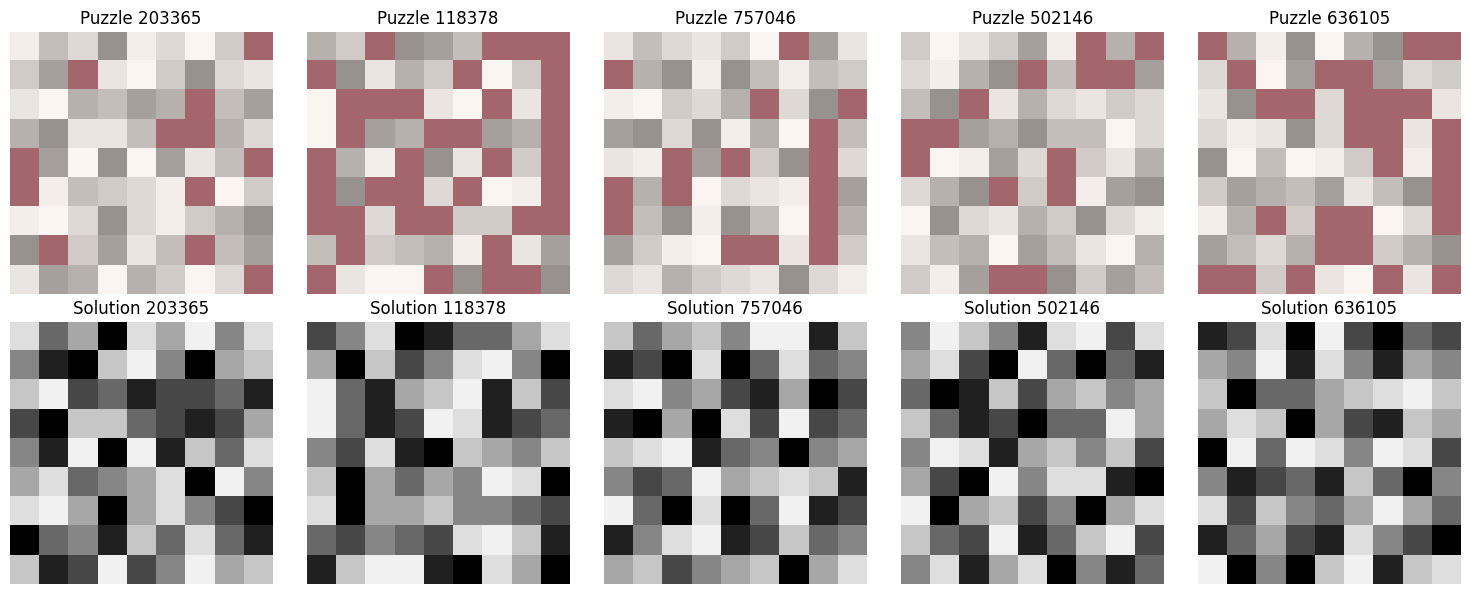

In [3]:
if __name__ == "__main__":
    
    
    # Save the generated dataset
    sudoku = SudokuGenerator()
    save_path = 'SudokuData/sudoku_dataset.pt'  # Specify your desired path
    

    # Plot some puzzles and solutions
    puzzles, solutions, num_holes = sudoku.load_dataset(path=save_path)
    plot_sudoku(puzzles, solutions, n=5)
   

    # Load the dataset (optional)
    

In [25]:




def change_to_one_hot(data):
    for n in range(len(data)):
        n_dim_empty = []
        for i in range(len(data[n])):
            i_dim_empty = []
            for j in range(len(data[n][i])):
                value = data[n][i][j]

                one_hot = torch.zeros(1,10)
                one_hot[0][value] = 1 

                #print(puzzles[n][i][j])
                i_dim_empty.append(one_hot)
            n_dim_empty.append(i_dim_empty)   


                
    return n_dim_empty


k1 = change_to_one_hot(puzzles[0:1000])

In [ ]:
k1 = torch.Tensor(k1)

In [ ]:


def change_to_one_hot(data):
    n_dim_list = []  # List to hold each 3D one-hot encoded puzzle
    for n in range(len(data)):
        # Create a tensor to hold the one-hot encoded puzzle
        one_hot_data = torch.zeros(9, 9, 10)  # Shape (9, 9, 10)
        
        for i in range(9):  # Iterate through rows
            for j in range(9):  # Iterate through columns
                value = data[n][i][j]
                one_hot_data[i][j][value] = 1  # Set the corresponding index to 1
                
        n_dim_list.append(one_hot_data)  # Append the one-hot encoded puzzle to the list

    return torch.stack(n_dim_list)  # Stack all puzzles into a single tensor

# Example usage

puzzles_one_hot = change_to_one_hot(puzzles)  # Convert first 1000 puzzles to one-hot encoded tensors
solutions_one_hot=change_to_one_hot(solutions)


dataset = {
            'puzzles': puzzles_one_hot,
            'solutions': solutions_one_hot,
            'num_holes': num_holes  # Save the number of holes for each puzzle
        }
        
save_path = 'SudokuData/sudoku_dataset_OneHot.pt'  # Specify your desired path
torch.save(dataset, path)
print(f"Dataset saved as {path}")


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def change_to_one_hot(data):
    n_samples = len(data)
    
    # Create a tensor to hold all one-hot encoded puzzles on the device
    one_hot_data = torch.zeros(n_samples, 9, 9, 10, device=device)  # Shape (n_samples, 9, 9, 10)
    
    for n in range(n_samples):
        values = data[n].to(device)  # Move current puzzle to device
        one_hot_data[n][torch.arange(9).unsqueeze(1), torch.arange(9), values] = 1

    return one_hot_data
puzzles_one_hot = change_to_one_hot(puzzles)  # Convert first 1000 puzzles to one-hot encoded tensors

In [4]:


def change_to_one_hot(data):
    n_samples = len(data)
    
    # Create a tensor to hold all one-hot encoded puzzles
    one_hot_data = torch.zeros(n_samples, 9, 9, 10, device='cuda' if torch.cuda.is_available() else 'cpu')  # Shape (n_samples, 9, 9, 10)
    
    for n in range(n_samples):
        # Get the puzzle values for the current sample and ensure it's a Long tensor
        values = data[n].to(torch.long)  # Ensure values are of type Long
        
        # Create row and column indices
        row_indices = torch.arange(9).unsqueeze(1)  # Shape (9, 1)
        col_indices = torch.arange(9)  # Shape (9)

        # Use advanced indexing to set the one-hot encoded values
        one_hot_data[n][row_indices, col_indices, values] = 1

    return one_hot_data

# Example usage
puzzles_one_hot = change_to_one_hot(puzzles)  # Convert puzzles to one-hot encoded tensors
solutions_one_hot = change_to_one_hot(solutions)  # Convert solutions to one-hot encoded tensors

dataset = {
            'puzzles': puzzles_one_hot,
            'solutions': solutions_one_hot,
            'num_holes': num_holes  # Save the number of holes for each puzzle
        }
        
save_path = 'SudokuData/sudoku_dataset_OneHot.pt'  # Specify your desired path
torch.save(dataset, save_path)
print(f"Dataset saved as {save_path}")


Dataset saved as SudokuData/sudoku_dataset_OneHot.pt
